In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining some utility functions:

In [3]:
def load_grayscale_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Could not load image: {path}")
    return img

def show_image(title, img, cmap='gray'):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def psnr(original, reconstructed):
    mse = np.mean((original.astype(np.float32) - reconstructed.astype(np.float32)) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

def load_images_from_folder(folder):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp')
    images = []
    file_list = []
    for file in os.listdir(folder):
        if file.lower().endswith(image_extensions):
            file_path = os.path.join(folder, file)
            img = load_grayscale_image(file_path)
            images.append(img)
            file_list.append(file_path)
    return images, file_list

Vector Quantization

In [4]:
class VectorQuantizer:
    def __init__(self, block_size=(4,4), epsilon=0.001, max_iter=50):
        self.block_size = block_size
        self.epsilon = epsilon
        self.max_iter = max_iter

    def extract_blocks(self, image):
        h, w = image.shape
        bh, bw = self.block_size


        pad_h = (bh - h % bh) % bh
        pad_w = (bw - w % bw) % bw


        padded = cv2.copyMakeBorder(image,
                                   0, pad_h, 0, pad_w,
                                   cv2.BORDER_REPLICATE)


        blocks = []
        for i in range(0, padded.shape[0], bh):
            for j in range(0, padded.shape[1], bw):
                block = padded[i:i+bh, j:j+bw].flatten()
                blocks.append(block)

        return np.array(blocks, dtype=np.float32) / 255.0

    def train_codebook(self, training_blocks, codebook_size):

        codebook = [np.clip(np.mean(training_blocks, axis=0), 0.0, 1.0)]
        codebook = codebook[:1]

        while len(codebook) < codebook_size:
            new_codebook = []
            for cb in codebook:
                new_codebook.append(np.clip(cb * (1 + self.epsilon), 0.0, 1.0))
                new_codebook.append(np.clip(cb * (1 - self.epsilon), 0.0, 1.0))
            codebook = np.array(new_codebook)


            prev_distortion = np.inf
            for _ in range(self.max_iter):
                diff = training_blocks[:, None] - codebook
                distances = np.sqrt(np.sum(np.square(diff), axis=2) + 1e-8)

                nearest = np.argmin(distances, axis=1)
                new_codebook = []

                for i in range(len(codebook)):
                    cluster = training_blocks[nearest == i]
                    if len(cluster) > 0:
                        new_cb = np.clip(np.mean(cluster, axis=0), 0.0, 1.0)
                    else:
                        new_cb = codebook[i]
                    new_codebook.append(new_cb)

                codebook = np.array(new_codebook)
                curr_distortion = np.mean(np.min(distances, axis=1))

                if abs(prev_distortion - curr_distortion)/curr_distortion < 0.001:
                    break
                prev_distortion = curr_distortion

        return codebook[:codebook_size]

    def quantize(self, image, codebook):
        h, w = image.shape
        blocks = self.extract_blocks(image)

        diff = blocks[:, None] - codebook
        distances = np.sqrt(np.sum(np.square(diff), axis=2))
        indices = np.argmin(distances, axis=1)

        quantized = np.zeros_like(image, dtype=np.uint8)
        for idx, (i, j) in enumerate([(x,y) for x in range(0,h,4) for y in range(0,w,4)]):
            patch = codebook[indices[idx]].reshape(4,4) * 255
            quantized[i:i+4, j:j+4] = np.clip(patch, 0, 255).astype(np.uint8)

        return quantized

DCT

In [7]:
def snr(original, reconstructed):
    original = original.astype(np.float64)
    reconstructed = reconstructed.astype(np.float64)
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - reconstructed) ** 2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

def zigzag_indices(n=8):
    indices = []
    for s in range(2 * n - 1):
        if s < n:
            if s % 2 == 0:
                for i in range(s, -1, -1):
                    j = s - i
                    indices.append((i, j))
            else:
                for i in range(0, s + 1):
                    j = s - i
                    indices.append((i, j))
        else:
            if s % 2 == 0:
                for i in range(n - 1, s - n, -1):
                    j = s - i
                    indices.append((i, j))
            else:
                for i in range(s - n + 1, n):
                    j = s - i
                    indices.append((i, j))
    return np.array(indices, dtype=np.int32)

class DCTCompressor:
    def __init__(self):
        self.zigzag = zigzag_indices(8)

    def dct2(self, block):
        return dct(dct(block.T, norm='ortho').T, norm='ortho')

    def idct2(self, block):
        return idct(idct(block.T, norm='ortho').T, norm='ortho')

    def compress(self, image, K):
        h, w = image.shape
        pad_h = (8 - h % 8) if h % 8 != 0 else 0
        pad_w = (8 - w % 8) if w % 8 != 0 else 0
        padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant')
        recon = np.zeros_like(padded, dtype=np.float32)
        for i in range(0, padded.shape[0], 8):
            for j in range(0, padded.shape[1], 8):
                block = padded[i:i+8, j:j+8].astype(np.float32)
                dct_block = self.dct2(block)
                mask = np.zeros((8,8), dtype=np.float32)
                for idx in range(K):
                    pos = self.zigzag[idx]
                    mask[pos[0], pos[1]] = 1.0
                dct_thresh = dct_block * mask
                block_recon = self.idct2(dct_thresh)
                recon[i:i+8, j:j+8] = block_recon
        recon = recon[:h, :w]
        recon = np.clip(recon, 0, 255).astype(np.uint8)
        return recon

    def run(self, image, Ks=[2, 4, 8, 16, 32]):
        results = {}
        for K in Ks:
            recon = self.compress(image, K)
            curr_psnr = psnr(image, recon)
            curr_snr = snr(image, recon)  # Calculate SNR
            results[K] = {
                "reconstructed": recon,
                "PSNR": curr_psnr,
                "SNR": curr_snr  # Store SNR
            }
            print(f"DCT with K={K} coefficients: "
                  f"PSNR = {curr_psnr:.2f} dB, "
                  f"SNR = {curr_snr:.2f} dB")  # Show both metrics
            show_image(f"DCT Reconstructed (K={K})", recon)
        return results

Select Compression Method:
1: Vector Quantization
2: DCT Compression
Enter your choice (1 or 2): 2

Processing: baboon.png
DCT with K=2 coefficients: PSNR = 20.16 dB, SNR = 14.70 dB


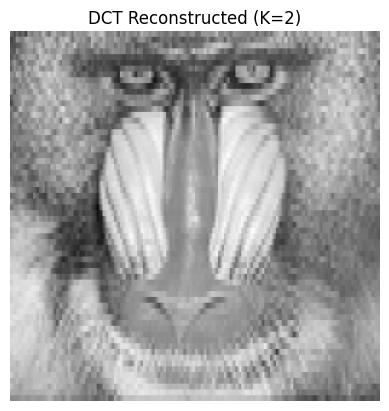

DCT with K=4 coefficients: PSNR = 21.15 dB, SNR = 15.68 dB


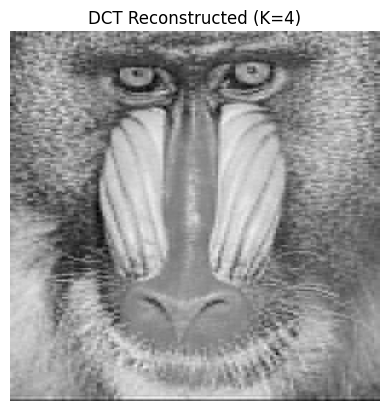

DCT with K=8 coefficients: PSNR = 22.09 dB, SNR = 16.62 dB


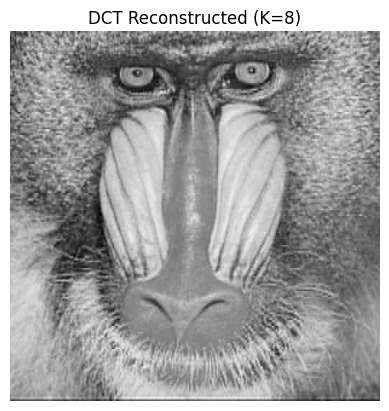

DCT with K=16 coefficients: PSNR = 24.15 dB, SNR = 18.68 dB


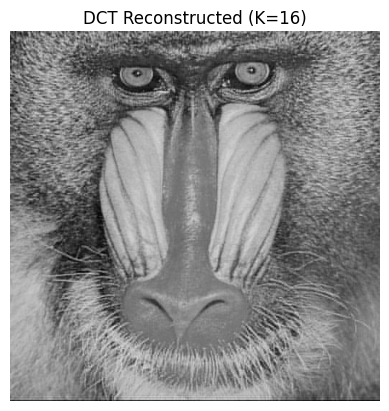

DCT with K=32 coefficients: PSNR = 27.68 dB, SNR = 22.21 dB


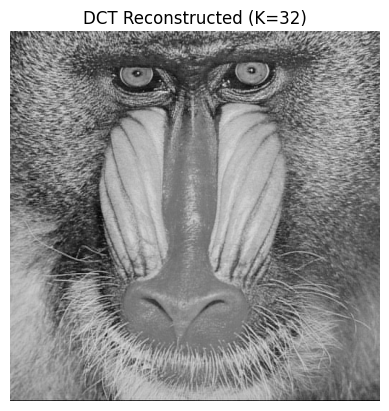


Processing: arctichare.png
DCT with K=2 coefficients: PSNR = 25.66 dB, SNR = 24.61 dB


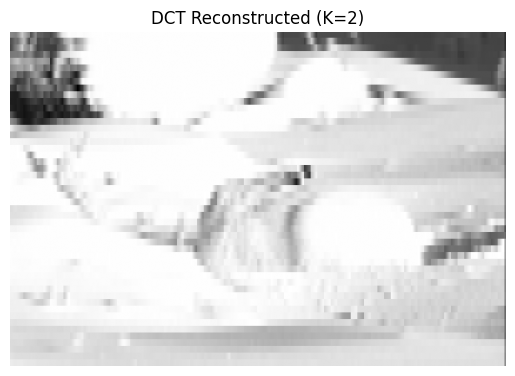

DCT with K=4 coefficients: PSNR = 30.29 dB, SNR = 29.24 dB


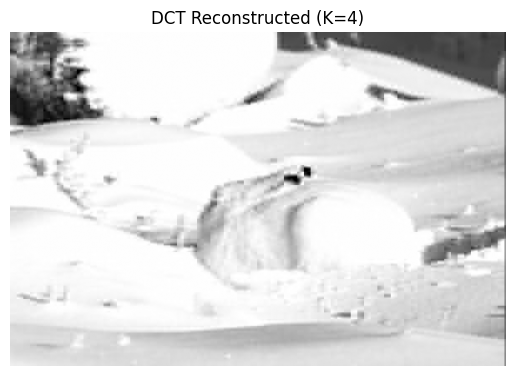

DCT with K=8 coefficients: PSNR = 33.94 dB, SNR = 32.89 dB


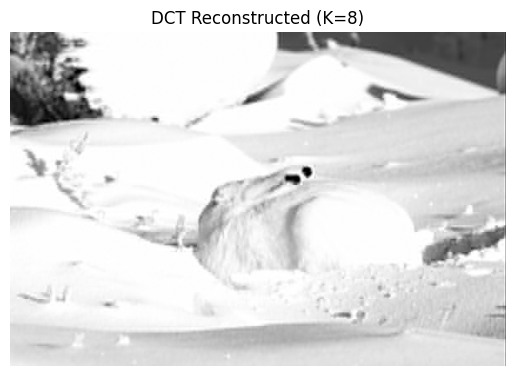

DCT with K=16 coefficients: PSNR = 39.62 dB, SNR = 38.57 dB


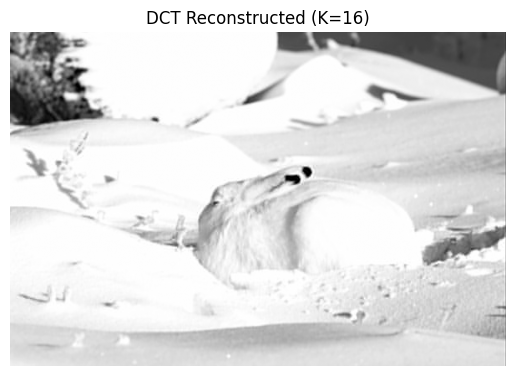

DCT with K=32 coefficients: PSNR = 47.00 dB, SNR = 45.95 dB


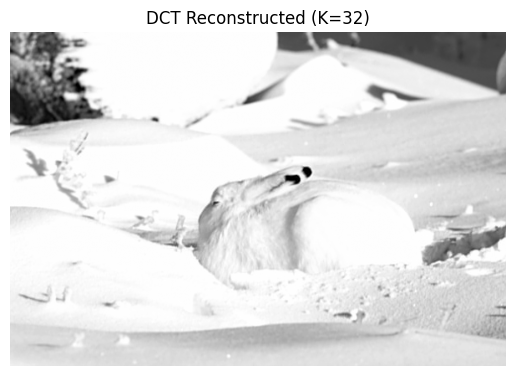

In [11]:
print("Select Compression Method:")
print("1: Vector Quantization")
print("2: DCT Compression")
choice = input("Enter your choice (1 or 2): ").strip()

folder = '/content/drive/MyDrive/sample_image'
images, file_list = load_images_from_folder(folder)
output_dir = '/content/drive/MyDrive/outputs'
os.makedirs(output_dir, exist_ok=True)
if not images:
    print(f"No images found in folder {folder}")

if choice == '1':
    training_set = images[:10]
    test_images = images[10:12]
    test_names = [os.path.basename(p) for p in file_list[10:12]]
    codebook_sizes = [32, 64, 128, 256]  # Added all required sizes

    for test_img, name in zip(test_images, test_names):
        print(f"\nProcessing: {name}")
        img_output_dir = os.path.join(output_dir, os.path.splitext(name)[0])
        os.makedirs(img_output_dir, exist_ok=True)

        # Save original image
        cv2.imwrite(os.path.join(img_output_dir, 'original.jpg'), test_img)

        vq = VectorQuantizer()
        results = {'single': {}, 'multi': {}}

        # Process single-image codebooks
        blocks = vq.extract_blocks(test_img)
        for L in codebook_sizes:
            codebook = vq.train_codebook(blocks, L)
            recon = vq.quantize(test_img, codebook)
            results['single'][L] = recon
            cv2.imwrite(os.path.join(img_output_dir, f'single_L{L}.jpg'), recon)

        # Process multi-image codebooks
        multi_blocks = np.vstack([vq.extract_blocks(img) for img in training_set])
        for L in codebook_sizes:
            codebook = vq.train_codebook(multi_blocks, L)
            recon = vq.quantize(test_img, codebook)
            results['multi'][L] = recon
            cv2.imwrite(os.path.join(img_output_dir, f'multi_L{L}.jpg'), recon)

        # Display results
        print("\nSingle-image Codebook Results:")
        for L in codebook_sizes:
            print(f"L={L}: {psnr(test_img, results['single'][L]):.2f} dB")

        print("\nMulti-image Codebook Results:")
        for L in codebook_sizes:
            print(f"L={L}: {psnr(test_img, results['multi'][L]):.2f} dB")

        # Create comparison plots
        fig, ax = plt.subplots(2, 4, figsize=(20, 10))

        # Single-image codebooks
        for i, L in enumerate(codebook_sizes):
            ax[0,i].imshow(results['single'][L], cmap='gray')
            ax[0,i].set_title(f'Single L={L}\nPSNR: {psnr(test_img, results["single"][L]):.2f} dB')
            ax[0,i].axis('off')

        # Multi-image codebooks
        for i, L in enumerate(codebook_sizes):
            ax[1,i].imshow(results['multi'][L], cmap='gray')
            ax[1,i].set_title(f'Multi L={L}\nPSNR: {psnr(test_img, results["multi"][L]):.2f} dB')
            ax[1,i].axis('off')

        plt.tight_layout()
        fig.savefig(os.path.join(img_output_dir, 'comparison_plot.png'), dpi=150)
        plt.close(fig)


elif choice == '2':
    # Process specific test images
    target_images = {'arctichare', 'baboon'}  # Case-sensitive names
    test_images = []
    test_names = []

    # Match images with filenames
    for img, path in zip(images, file_list):
        fname = os.path.splitext(os.path.basename(path))[0]
        if fname.lower() in {name.lower() for name in target_images}:
            test_images.append(img)
            test_names.append(os.path.basename(path))

    if not test_images:
        print("No matching images found. Ensure you have 'arctichare' and 'baboon' in your folder.")
        exit()

    for test_img, name in zip(test_images, test_names):
        print(f"\nProcessing: {name}")
        img_output_dir = os.path.join(output_dir, os.path.splitext(name)[0])
        os.makedirs(img_output_dir, exist_ok=True)

        # Save original
        cv2.imwrite(os.path.join(img_output_dir, 'original.jpg'), test_img)
        dct_comp = DCTCompressor()
        results = dct_comp.run(test_img, Ks=[2, 4, 8, 16, 32])

        # Save metrics to file (fixed formatting)
        with open(os.path.join(img_output_dir, 'metrics.txt'), 'w') as f:
            for K in [2, 4, 8, 16, 32]:
                recon = results[K]["reconstructed"]
                cv2.imwrite(os.path.join(img_output_dir, f'K{K}.jpg'), recon)
                f.write(f"K={K}: PSNR={results[K]['PSNR']:.2f} dB, "  # Fixed colon position
                        f"SNR={results[K]['SNR']:.2f} dB\n")

        # Create comparison plot
        plt.figure(figsize=(15, 8))
        plt.subplot(2, 3, 1)
        plt.imshow(test_img, cmap='gray')
        plt.title('Original Image')

        for i, K in enumerate([2, 4, 8, 16, 32], start=2):
            plt.subplot(2, 3, i)
            plt.imshow(results[K]["reconstructed"], cmap='gray')
            plt.title(f'K={K}\nPSNR: {results[K]["PSNR"]:.2f} dB\nSNR: {results[K]["SNR"]:.2f} dB')

        plt.tight_layout()
        plt.savefig(os.path.join(img_output_dir, 'dct_comparison.png'), dpi=150)
        plt.close()

else:
    print("Invalid choice. Exiting.")